# Deep Mixture Density Network

Reference
- [Edward: Mixture Density Networks](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [ML Design: Mixture Density Networks with TensorFlow](http://edwardlib.org/tutorials/mixture-density-network)

For general regression problem, given a dataset $\{X, Y\}$, we try to fit the model parameters $\theta$ such that we can fairly predict the value of $y_i$ given $x_i$

$$\hat{y_i} = f(x_i; \theta)$$

In many application, we might have one-to-many relationship between $X$ and $Y$. Instead of predicting a single value, predicting an entire conditional distribution would be a better idea. In math term, we write

$$p_{y_i}(y|x=x_i) = f(y; x_i, \theta)$$

In this notebook, we will use $k$ Guassian kernel $N(\mu_j, \sigma_j^2)$ with associated weight $w_j$ to approximate the conditional PDF $p_{y_i}(y|x=x_i)$, so that

$$p_{y_i}(y|x=x_i) \approx \sum_j^k w_j \phi(y; \mu_j, \sigma_j^2)$$

And the parameters $w_j, \mu_j, \sigma_j^2$ are all functions of $x_i$, where the functions are provided by a (deep) neural network. Apparently, the conditional distribution of $y_i$ is not normal anymore, so the mixture density is capable of capturing non-normal characteristics such as fat tail and multiple peaks. In such architecture (we call it Mixture Density Network, or MDN), we will use Maximum Likelihood Estimation (MLE) to obtain the parameters in MDN.

In [1]:
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from gmd_util import PDF_gmd, CDF_gmd
import tensorflow as tf

%matplotlib inline

## 1. Create Dataset

In [2]:
def build_dataset(N, test_size):
    
    n1, n2, n3 = int(N * 0.4), int(N * 0.4), N - int(N * 0.8)
    
    y1 = np.random.uniform(-10.5, 10.5, n1)
    e1 = np.random.normal(size=n1)  # random noise
    x1 = -1 + np.sin(0.6 * y1) * 7 - np.sinh(0.5 * y1) * 0.6 + y1 * 0.5 + e1 * 3.0
    
    e2 = np.random.normal(size=n2)
    y2 = np.random.uniform(-2.5, 2.5, n2) + np.sign(e2) * np.random.normal(size=n2)**2
    x2 = 1 + np.cos(0.4 * y2) * 8 - y2 * 6 + e2 * 3.0
    
    e3 = np.random.normal(size=n3)
    x3 = np.random.uniform(-60, 60, size=n3) + e3**3
    y3 = np.random.normal(loc=x3*0.1, scale=np.abs(x3)*0.05, size=n3)
    
    x_data = np.r_[x1.reshape((n1, 1)), x2.reshape((n2, 1)), x3.reshape((n3, 1))]
    y_data = np.r_[y1.reshape((n1, 1)), y2.reshape((n2, 1)), y3.reshape((n3, 1))]
    
    return train_test_split(x_data, y_data, test_size=test_size, random_state=30)

Size of features in training data: (12000, 1)
Size of output in training data: (12000, 1)
Size of features in test data: (3000, 1)
Size of output in test data: (3000, 1)


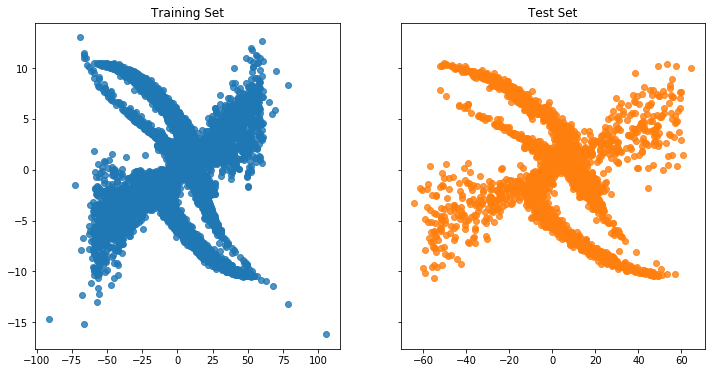

In [3]:
X_train, X_test, y_train, y_test = build_dataset(15000, test_size=0.2)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)

ax[0].set_title('Training Set')
ax[1].set_title('Test Set')
sns.regplot(X_train, y_train, fit_reg=False, ax=ax[0])
sns.regplot(X_test, y_test, fit_reg=False, ax=ax[1])

## 2. Design and fit MDN

In [4]:
# placeholder
def init_placeholder(n_feature):
    A0 = tf.placeholder(dtype=tf.float32, shape=[None, n_feature], name="X")
    Y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="Y")
    return A0, Y

def dense_NN(A0, n_hidden, n_kernel, dropout_rate):
    # layer 1
    A1 = tf.layers.dense(inputs=A0, units=n_hidden[0], activation=tf.nn.relu, name='A1')
    D1 = tf.layers.dropout(inputs=A1, rate=dropout_rate, name='D1')

    # layer 2
    A2 = tf.layers.dense(inputs=D1, units=n_hidden[1], activation=tf.nn.relu, name='A2')
    # start forking: mu, sigma, weight
    D2_0 = tf.layers.dropout(inputs=A2, rate=dropout_rate, name='D2_0')
    D2_1 = tf.layers.dropout(inputs=A2, rate=dropout_rate, name='D2_1')
    D2_2 = tf.layers.dropout(inputs=A2, rate=dropout_rate, name='D2_2')
    
    # layer 3
    A3_0 = tf.layers.dense(inputs=D2_0, units=n_hidden[2], activation=tf.nn.relu, name='A3_0')
    A3_1 = tf.layers.dense(inputs=D2_1, units=n_hidden[2], activation=tf.nn.relu, name='A3_1')
    A3_2 = tf.layers.dense(inputs=D2_1, units=n_hidden[2], activation=tf.nn.relu, name='A3_2')
    
    D3_0 = tf.layers.dropout(inputs=A3_0, rate=dropout_rate, name='D3_0')
    D3_1 = tf.layers.dropout(inputs=A3_1, rate=dropout_rate, name='D3_1')
    D3_2 = tf.layers.dropout(inputs=A3_2, rate=dropout_rate, name='D3_2')
    
    # final layer
    F_0 = tf.layers.dense(inputs=D3_0, units=n_kernel, name='F_0')
    F_1 = tf.layers.dense(inputs=D3_1, units=n_kernel, name='F_1')
    F_2 = tf.layers.dense(inputs=D3_1, units=n_kernel, name='F_2')
        
    return F_0, F_1, F_2

# compute logit
def compute_logit(W0):
    W1 = tf.exp(tf.subtract(W0, tf.reduce_max(input_tensor=W0, axis=1, keepdims=True)))
    W = tf.multiply(W1, tf.reciprocal(tf.reduce_sum(W1, axis=1, keepdims=True)), name='Logit')
    return W

def get_MDN_coef(F):
    # from the final layer A3: [A3_0, A3_1, A3_2]
    MU = F[0]
    SIG = tf.exp(F[1], name='SIG')
    W = compute_logit(F[2])
    
    return MU, SIG, W

# core of normal density
def tf_normal_density(Y, MU, SIG):
    invs = tf.reciprocal(SIG)
    z = tf.multiply(tf.subtract(Y, MU), invs)
    return tf.multiply(tf.exp(- tf.square(z) / 2), invs, name='normal_density')

# MLE
def get_lossfunc(Y, MU, SIG, W):
    Nd = tf_normal_density(Y, MU, SIG)
    LL = tf.reduce_sum(tf.multiply(Nd, W), axis=1, keepdims=True, name='likelihood')
    logLL = -tf.log(LL, name='log_likelihood')
    L = tf.reduce_mean(logLL, name='loss_func')
    return L

In [5]:
n_feature = 1
n_kernel = 7
n_hidden = [15, 15, 10]
n_epoch = 5000
batch_size = 512
dropout_rate = 0.2

tf.reset_default_graph()

A0, Y = init_placeholder(n_feature)
A3 = dense_NN(A0, n_hidden=n_hidden, n_kernel=n_kernel, dropout_rate=dropout_rate)
MU, SIG, W = get_MDN_coef(A3)
L = get_lossfunc(Y, MU, SIG, W)
train_op = tf.train.AdamOptimizer().minimize(L)

train_loss, test_loss = np.zeros(n_epoch), np.zeros(n_epoch)
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(n_epoch):

    x, y = shuffle(X_train, y_train)
    for j in range(0, x.shape[0], batch_size):
        sess.run(train_op, feed_dict={A0: x[j:j + batch_size], Y: y[j:j + batch_size]})

    train_loss[i] = sess.run(L, feed_dict={A0: X_train, Y: y_train})
    test_loss[i] = sess.run(L, feed_dict={A0: X_test, Y: y_test})
    
    # check model
    if np.isnan(train_loss[i]) or np.isnan(test_loss[i]):
        break

    if i % 500 == 0:
        print('i = %d, Train Loss = %.4f, Test Loss = %.4f'%(i, train_loss[i], test_loss[i]))

i = 0, Train Loss = 2.3417, Test Loss = 2.3333
i = 500, Train Loss = 0.9689, Test Loss = 0.9651
i = 1000, Train Loss = 0.9503, Test Loss = 0.9476
i = 1500, Train Loss = 0.9534, Test Loss = 0.9478
i = 2000, Train Loss = 0.9560, Test Loss = 0.9518
i = 2500, Train Loss = 0.9424, Test Loss = 0.9409
i = 3000, Train Loss = 0.9384, Test Loss = 0.9421
i = 3500, Train Loss = 0.9401, Test Loss = 0.9377
i = 4000, Train Loss = 0.9343, Test Loss = 0.9378
i = 4500, Train Loss = 0.9373, Test Loss = 0.9455


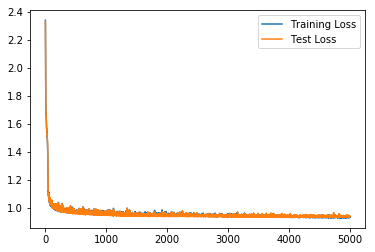

In [6]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()

## 3. Sample from MDN

In [7]:
# get GMD parameters
mu, sig, w = sess.run([MU, SIG, W], feed_dict={A0: X_test})

mul = 2
y_gen = np.zeros(len(X_test) * mul)
x_gen = np.repeat(X_test, mul, axis=1).reshape(mul * X_test.shape[0])

for i, param in enumerate(zip(mu, sig, w)):
    cum_prob = np.cumsum(param[2])
    if mul == 1:
        k = np.argmax(np.random.uniform(size=1) < cum_prob, axis=0)
        y_gen[i] = np.random.normal(loc=param[0][k], scale=param[1][k], size=1)        
    else:
        k_class = np.argmax(np.random.uniform(size=(mul, 1)) < cum_prob, axis=1)
        y_gen[i*mul: (i+1)*mul] = [np.random.normal(loc=param[0][k], scale=param[1][k], size=1) for k in k_class]

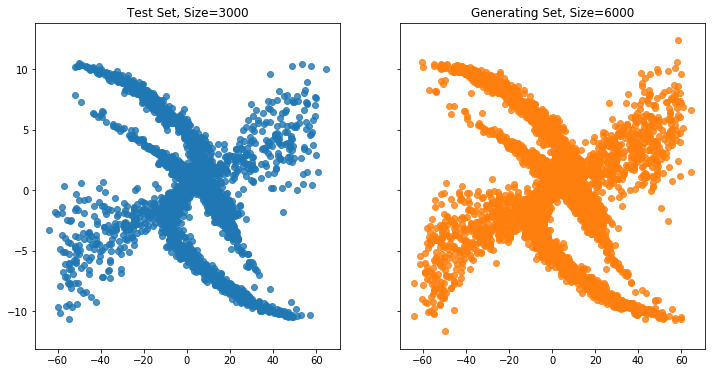

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)

ax[0].set_title('Test Set, Size=%d'%len(y_test))
ax[1].set_title('Generating Set, Size=%d'%len(y_gen))

sns.regplot(X_test, y_test, fit_reg=False, ax=ax[0])
sns.regplot(x_gen, y_gen, fit_reg=False, ax=ax[1])

## 4. Distribution of mixture density

Define "effective kernel" if a gaussian kernel in the GMD has weight greater than 1%

X = -50, # of effective kernels: 4
X = 0, # of effective kernels: 6
X = 50, # of effective kernels: 3


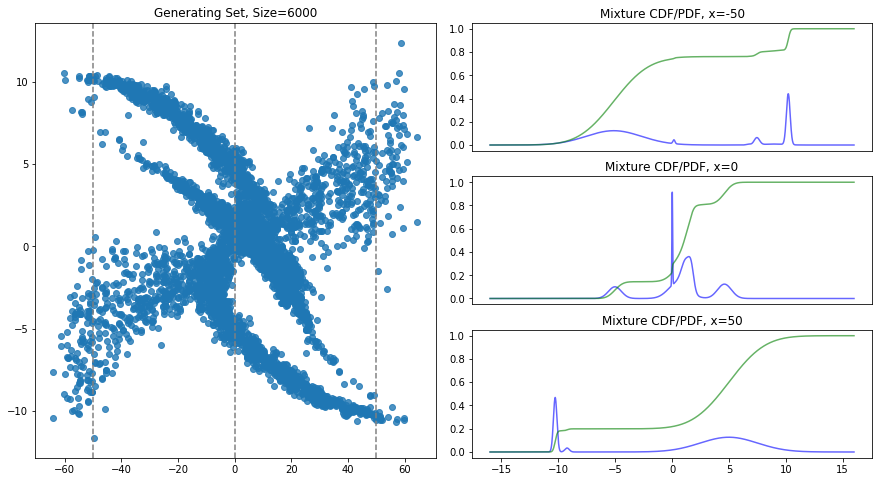

In [9]:
fig = plt.figure(figsize=(15,8))
gs = GridSpec(3, 4)

ax_left = plt.subplot(gs[:, :2])
ax_right = [fig.add_subplot(gs[i, 2:]) for i in range(3)]

ax_left.set_title('Generating Set, Size=%d'%len(y_gen))
sns.regplot(x_gen, y_gen, fit_reg=False, ax=ax_left)

lx = np.arange(-16, 16, 0.01)

for i, x in enumerate([-50, 0, 50]):
    ax_left.axvline(x, c='gray', ls='--')
    m, s, w = sess.run([MU, SIG, W], feed_dict={A0: np.array([[x]])})
    print('X = %.f, # of effective kernels: %d'%(x, len(w[w > 0.01])))
    
    pdf = PDF_gmd(logit=w.flatten(), mu=m.flatten(), sig=s.flatten())
    cdf = CDF_gmd(logit=w.flatten(), mu=m.flatten(), sig=s.flatten())

    ax_right[i].plot(lx, pdf(lx), c='blue', alpha=0.6)
    ax_right[i].plot(lx, cdf(lx), c='green', alpha=0.6)
    ax_right[i].set_title('Mixture CDF/PDF, x=%d'%x)
    
    if i != 2: ax_right[i].get_xaxis().set_visible(False)